In [1]:
import torch
from tqdm import tqdm

In [2]:
DEVICE = "cuda"
BATCH_SIZE = 16

In [3]:
import numpy as np
import torch
from typing import Optional
from scipy.optimize import linear_sum_assignment


def cluster_accuracy(y_true, y_predicted, cluster_number: Optional[int] = None):
    """
    Calculate clustering accuracy after using the linear_sum_assignment function in SciPy to
    determine reassignments.
    :param y_true: list of true cluster numbers, an integer array 0-indexed
    :param y_predicted: list  of predicted cluster numbers, an integer array 0-indexed
    :param cluster_number: number of clusters, if None then calculated from input
    :return: reassignment dictionary, clustering accuracy
    """
    if cluster_number is None:
        cluster_number = (
            max(y_predicted.max(), y_true.max()) + 1
        )  # assume labels are 0-indexed
    count_matrix = np.zeros((cluster_number, cluster_number), dtype=np.int64)
    for i in range(y_predicted.size):
        count_matrix[y_predicted[i], y_true[i]] += 1

    row_ind, col_ind = linear_sum_assignment(count_matrix.max() - count_matrix)
    reassignment = dict(zip(row_ind, col_ind))
    accuracy = count_matrix[row_ind, col_ind].sum() / y_predicted.size
    return reassignment, accuracy

In [4]:
from torch import nn

class ClusteringLayer(nn.Module):
    
    def __init__(self, initial_centroids, alpha=1.0):
        super(ClusteringLayer, self).__init__()
        self.weights = nn.Parameter(initial_centroids)
        self.alpha = alpha
    
    def forward(self, inputs):
        """
        Takes a batch of input embeddings of shape (batch_size, embedding_size).
        And computes of soft clustering based in on the centroids.
        """    
        norm_squared = torch.sum((inputs.unsqueeze(1) - self.weights) ** 2, 2)
        numerator = 1.0 / (1.0 + (norm_squared / self.alpha))
        power = float(self.alpha + 1) / 2
        q = numerator ** power
        return q
    
    def __repr__(self):
        return str(self.weights.shape)

In [5]:
class SentenceBertForClustering(nn.Module):
    
    def __init__(self, sentencebert_model, initial_centroids):
        super(SentenceBertForClustering, self).__init__()
        self.sentencebert_model = sentencebert_model
        self.initial_centroids = initial_centroids
        self.clustering_layer = ClusteringLayer(initial_centroids=initial_centroids)
        
    def target_probability_distribution(self, q):
        weight = (q ** 2) / torch.sum(q, 0)
        return (weight.t() / torch.sum(weight, 1)).t()
        
    def forward(self, inputs):
        distilbert_outputs = self.sentencebert_model(inputs)
        cls_embeddings = distilbert_outputs['sentence_embedding'].squeeze(1)
        
        q = self.clustering_layer(cls_embeddings)
        p = self.target_probability_distribution(q)
        return q, p

In [6]:
from torch.utils.data import Dataset, DataLoader


class TextDataset(Dataset):
    def __init__(self, texts, labels):
        
        self.texts = texts
        self.labels = labels


        self.labels = torch.tensor(self.labels, dtype=torch.float)
        
    def __getitem__(self, index):
        return self.texts[index], labels[index]

    
    def __len__(self):
        return len(self.texts)

In [7]:
from sklearn.datasets import fetch_20newsgroups
import numpy as np
data = fetch_20newsgroups(
    #categories=['comp.graphics', 'talk.religion.misc', 'rec.autos', 'sci.med'],
    remove=('headers', 'footers', 'quotes'),
    shuffle=True,
    random_state=42
)
texts, labels = data.data, data.target


In [8]:
import tensorflow_datasets as tfds
texts, labels = [], []
for ex in tfds.load('imdb_reviews', split='test'):
    texts.append(str(ex['text'].numpy()))
    labels.append(ex['label'].numpy())
labels = np.array(labels)

In [9]:
print(texts[0])

b"I've watched the movie actually several times. And what i want to say about it is the only thing that made this movie high rank was the Burak Altay's incredible performance, absolutely nothing but that. Not even those silly model named Deniz Akkaya and some of these popular names at times in the movie... Burak is definitely very talented i've seen a few jobs he made and been through. Even though this is kind of horror movie, he's doing really good job in comedy movies and also in dramas too. I bet most of you all saw Asmali Konak the movie and TV series, those two would go for an example... All i'm gonna say is you better watch out for the new works coming out from Burak then you'll see.. Keep the good work bro, much love.."


In [10]:
print(*map(len, (texts, labels)), sep=' | ')

25000 | 25000


In [11]:
data = TextDataset(texts, labels)
data_loader = DataLoader(dataset=data, batch_size=16, shuffle=False)

In [12]:
from sentence_transformers import SentenceTransformer
sentencebert_model = SentenceTransformer('distilbert-base-nli-mean-tokens')
sentencebert_model.to(DEVICE)

SentenceTransformer(
  (0): Transformer(
    (auto_model): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0): TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (ffn): FFN(
              (dro

In [13]:
def features_to_tensor(features, device):
    return {key: torch.tensor(value, device=device) for key, value in features.items()}

In [14]:
embeddings = []

for text in tqdm(texts):
    features = features_to_tensor(sentencebert_model.tokenizer([text], padding=True, truncation=True), device=DEVICE)
    cls = sentencebert_model(features)['sentence_embedding']
    embeddings.append(cls.cpu().detach().numpy())

100%|██████████| 25000/25000 [08:33<00:00, 48.71it/s] 


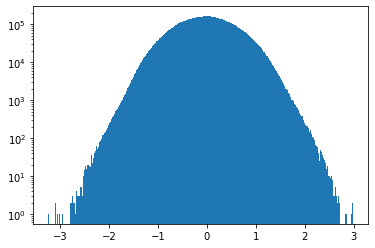

In [15]:
import matplotlib.pyplot as plt

plt.hist(np.array(embeddings).T.flatten(), bins=512)
plt.yscale('log')
plt.show()

In [16]:
embeddings = np.array(embeddings).squeeze(axis=1)

In [17]:
from umap import UMAP
from sklearn.decomposition import PCA
umap = UMAP(n_components=2)

Xr = umap.fit_transform(embeddings)

/home/keller/.conda/envs/cuda/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10006. The TBB threading layer is disabled.
  warnings.warn(problem)


<AxesSubplot:>

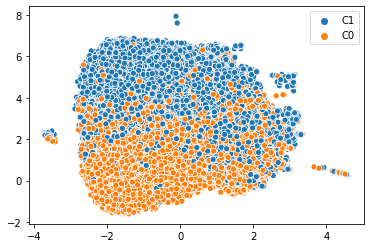

In [18]:
import seaborn as sns
sns.scatterplot(x=Xr[:,0], y=Xr[:,1], hue=[f'C{i}' for i in labels])

In [19]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)
kmeans_cluster = kmeans.fit_predict(embeddings)
kmeans_centroids = kmeans.cluster_centers_

In [20]:
cluster_accuracy(labels, kmeans_cluster)

({0: 0, 1: 1}, 0.78408)

In [21]:
kmeans_cluster = torch.from_numpy(kmeans_centroids).to(DEVICE)

In [22]:
cluster_model = SentenceBertForClustering(sentencebert_model=sentencebert_model, initial_centroids=kmeans_cluster)
cluster_model.to(DEVICE)

SentenceBertForClustering(
  (sentencebert_model): SentenceTransformer(
    (0): Transformer(
      (auto_model): DistilBertModel(
        (embeddings): Embeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (transformer): Transformer(
          (layer): ModuleList(
            (0): TransformerBlock(
              (attention): MultiHeadSelfAttention(
                (dropout): Dropout(p=0.1, inplace=False)
                (q_lin): Linear(in_features=768, out_features=768, bias=True)
                (k_lin): Linear(in_features=768, out_features=768, bias=True)
                (v_lin): Linear(in_features=768, out_features=768, bias=True)
                (out_lin): Linear(in_features=768, out_features=768, bias=True)
              )
              (sa_layer_norm): LayerNo

In [23]:
clustering_loss_fn = nn.KLDivLoss(reduction='batchmean')

In [24]:
def kl_divergence(pred, target):
    return torch.mean(torch.sum(target * torch.log(target/pred), dim=1))

In [25]:
from itertools import chain
optimizer = torch.optim.AdamW(params=cluster_model.parameters(), lr=0.00001)

In [26]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score


def train(epoch, t, cluster_model, data_loader, optimizer, clustering_loss_fn):
    
    cluster_model.train()
    
    # train part
    pbar = tqdm(data_loader)
    for batch_index, batch_data in enumerate(pbar):
        
        if batch_index % t == 0:
            pbar.set_description("Recomputing ps")
            # compute p for each batch and store it
            ps = {}
            for index, xi in enumerate(list(data_loader)[batch_index: batch_index + t]):
                texts, _ = xi
                inputs = cluster_model.sentencebert_model.tokenizer(
                    texts,
                    return_tensors='pt',
                    padding=True,
                    truncation=True
                )
                inputs = inputs.to('cuda')
                _, p = cluster_model(inputs)
                p = p.detach()
                ps[batch_index + index] = p

        inputs = inputs.to('cuda')
        # get inputs for the models
        texts, _ = batch_data
        inputs = cluster_model.sentencebert_model.tokenizer(
            texts,
            return_tensors='pt',
            padding=True,
            truncation=True
        )
        inputs = inputs.to('cuda')
        # do clustering task
        q, _ = cluster_model(inputs)
        #q = q.cpu().detach()
        p = ps[batch_index]
        clustering_loss = clustering_loss_fn(q, p)
        
        # do optimization step
        combined_loss = clustering_loss
        
        optimizer.zero_grad()  # clears the gradients (from previous optimization step)
        combined_loss.backward()  # backpropagation step through the model
        optimizer.step()  # updated the weights of each layer using the computed gradients
        
        pbar.set_description(f'''Epoch {epoch + 1} | Clustering Loss {clustering_loss.item()}''')
    
    # validation part
    with torch.no_grad():
        cluster_model.eval()
        true_labels = []
        predicted_labels = []
        for batch_index, batch_data in enumerate(pbar):
            texts, labels = batch_data
            inputs = cluster_model.sentencebert_model.tokenizer(
                texts,
                return_tensors='pt',
                padding=True,
                truncation=True
            )
            inputs = inputs.to('cuda')
            q, p = cluster_model(inputs)
            
            predicted_label = q.argmax(dim=1).cpu().detach().numpy()
            true_label = labels.cpu().detach().numpy()
            
            predicted_labels.extend(predicted_label)
            true_labels.extend(true_label)
            
        true_labels = np.array(true_labels).flatten()
        predicted_labels = np.array(predicted_labels).flatten()

        print('#' * 60)
        print(normalized_mutual_info_score(true_labels, predicted_labels))
        print(cluster_accuracy(true_labels, predicted_labels))
        print(adjusted_rand_score(true_labels, predicted_labels))
        return np.array(true_labels), np.array(predicted_labels)

In [28]:
for epoch in range(1):
    true, pred = train(
        epoch=epoch,
        t=1,
        cluster_model=cluster_model,
        data_loader=data_loader,
        optimizer=optimizer,
        clustering_loss_fn=kl_divergence
    )

Recomputing ps:   0%|          | 0/1563 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 24.00 MiB (GPU 0; 10.73 GiB total capacity; 1.30 GiB already allocated; 8.69 MiB free; 1.34 GiB reserved in total by PyTorch)

In [ ]:
tuned_embeddings = []

for text in tqdm(texts):
    features = features_to_tensor(sentencebert_model.tokenizer([text], padding=True, truncation=True), device=DEVICE)
    cls = sentencebert_model(features)['sentence_embedding']
    tuned_embeddings.append(cls.cpu().detach().numpy())

In [ ]:
tuned_embeddings = np.array(tuned_embeddings).squeeze(axis=1)

In [ ]:
import matplotlib.pyplot as plt

plt.hist(np.array(tuned_embeddings).T.flatten(), bins=512)
plt.yscale('log')
plt.show()

In [ ]:
from umap import UMAP
from sklearn.decomposition import PCA
umap = UMAP(n_components=2)

Xrt = umap.fit_transform(tuned_embeddings)

In [ ]:
import seaborn as sns
sns.scatterplot(x=Xrt[:,0], y=Xrt[:,1], hue=[f'C{i}' for i in labels])

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)
kmeans_cluster = kmeans.fit_predict(tuned_embeddings)

In [ ]:
cluster_accuracy(labels, kmeans_cluster)

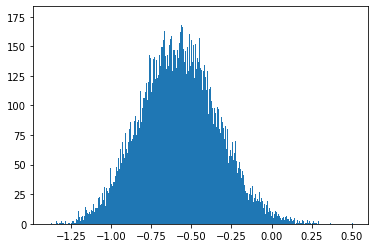

In [55]:
plt.hist(embeddings.T[650], bins=512)
#plt.yscale('log')
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=10).fit_transform(texts).todense()

In [ ]:
plt.hist(tfidf.T[0], bins=512)
plt.yscale('log')
plt.show()